# HUGS - HUb for Greenhouse gas data Science

## Overview

HUGS works in a modular way without a fixed hierarchical structure. 

There are multiple modules

* Datasources
* Instrument
* Sites
* Networks

For example they can be arranged as

* Network
    * Site
        * Instrument
            * Datasource
            * Datasource
            * Datasource
            

* Network
    * Datasource
    * Datasource
    * Datasource

There is no set fixed structure for these modules
        




Data can be stored within objects. These objects take the form of Python classes which hold other Python objects and links to data in the object store.

In the following code we will read in 3 data files, analyse the data contained within them, segment the data into sections which can be easily stored in the object store and then recombine these dataframes ready for export to the end user.

In [1]:
# Suppress some Pandas warnings - these will be fixed
import warnings
warnings.filterwarnings('ignore')
# Data pretty printer for nicer printing of data
import pprint

In [3]:
# For listing of objects in the object store
from objectstore.hugs_objstore import list_object_names
# To get the local bucket (a container for data in the object store)
from objectstore.local_bucket import get_local_bucket
# The object to process and store CRDS data
from processing._crds import CRDS

## Processing data

Here we read in 3 data files from the Bilsdale site and read them in using the read_filelist() function from the CRDS class

For each file this function
* Collects metadata
* Splits the data into separate dataframes for each gas
* Creates a Datasource object for the gas, holding data and metadata


In [4]:
filename = "data/bsd.picarro.1minute.248m.dat"

In [5]:
# Get a list of CRDS objects
crds = CRDS.read_file(filename)

In [6]:
crds.get_daterange()

(Timestamp('2014-01-30 10:52:30'), Timestamp('2014-01-30 14:20:30'))

We can view some of the data stored in each Datasource within this CRDS object

In [7]:
datasources = crds.get_datasources()

for d in datasources:
    data = d.get_data()
    # Print the top line of each dataframe
    print(data.head(2))

             Datetime  ch4 count  ch4 stdev  ch4 n_meas
0 2014-01-30 10:52:30    1960.24      0.236        26.0
1 2014-01-30 10:53:30    1959.31      0.502        26.0
             Datetime  co2 count  co2 stdev  co2 n_meas
0 2014-01-30 10:52:30     409.66      0.028        26.0
1 2014-01-30 10:53:30     409.50      0.058        26.0
             Datetime  co count  co stdev  co n_meas
0 2014-01-30 10:52:30    204.62     6.232       26.0
1 2014-01-30 10:53:30    200.78     5.934       26.0


## Visualisation

We can visualize some of this data



<IPython.core.display.Javascript object>


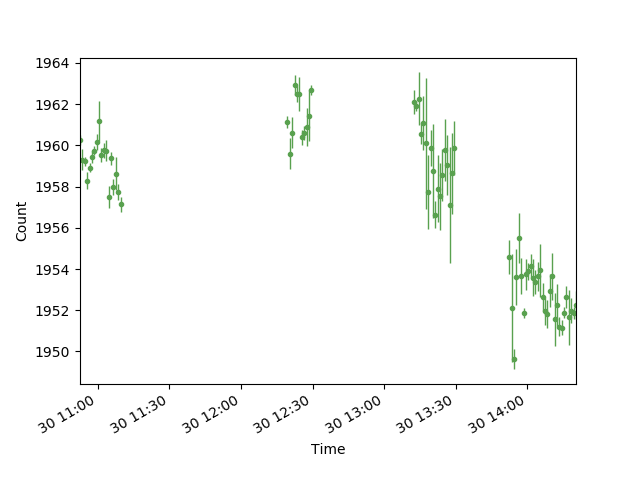

<IPython.core.display.Javascript object>


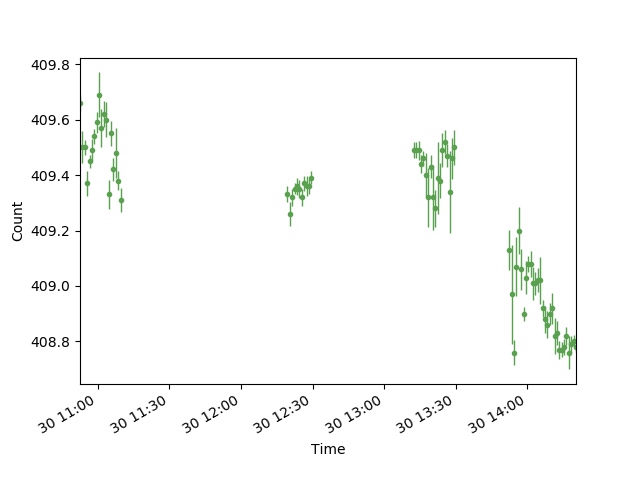

<IPython.core.display.Javascript object>


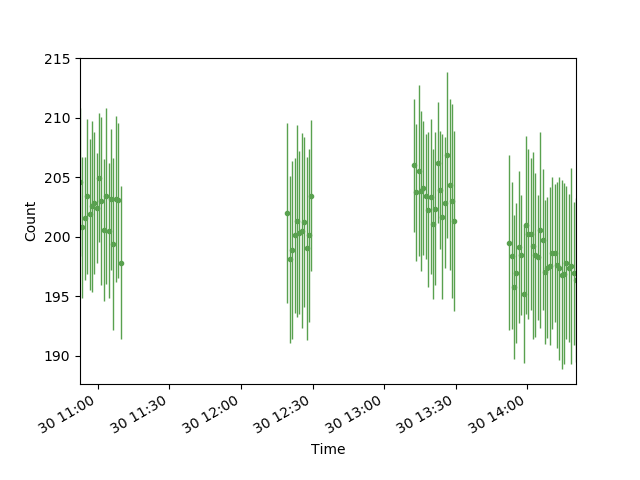

In [53]:
%matplotlib notebook
import random
# Get the first datasource
datasource = datasources[0]
for datasource in datasources:
    data = datasource.get_data()
    # Get column names
    col_names = list(data.columns)
    ax = data.plot(x="Datetime", y=col_names[1], elinewidth=1, linewidth=0, marker="o", markersize=3, 
                   yerr=col_names[2], legend=None, color="#59a14f")
    ax.set(xlabel="Time", ylabel="Count")




## Object Store

We can now store the data in the object store.

The data for each gas is stored within a Pandas DataFrame that gets converted into a compressed binary HDF5 file format similar to that used by NetCDF. Each datasource stores its data with a key containing its own universally unique identifier (UUID).

Each object has a .save() function that saves the object to the data store


In [36]:
# Get a bucket, a container used to store data in the object store
bucket = get_local_bucket()
# Save the object to the object store
crds.save(bucket)

This function then saves the CRDS object and each of its Datasources to the object store. 
As each Datasource holds gas data this in turn is saved by the save function of each Datasource.

We can now view the structure of the object store by querying the keys in the bucket

In [37]:
# List all the objects in the container
bucket_list = list_object_names(bucket)

# User PrettyPrinter to print them in a nicer way
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(bucket_list)


[ 'datasource/uuid/475b95fb-9d9b-4950-aef4-805d6b281e62',
  'datasource/uuid/0f8e9232-d3eb-4e34-b1ca-1d536ae72723',
  'datasource/uuid/338672a3-30c4-4655-b0f2-d05521d25ef2',
  'CRDS/uuid/909973de-ce20-4715-b8df-fca64861c95a',
  'data/uuid/338672a3-30c4-4655-b0f2-d05521d25ef2/2014-01-30T10:52:30_2014-01-30T14:20:30',
  'data/uuid/475b95fb-9d9b-4950-aef4-805d6b281e62/2014-01-30T10:52:30_2014-01-30T14:20:30',
  'data/uuid/0f8e9232-d3eb-4e34-b1ca-1d536ae72723/2014-01-30T10:52:30_2014-01-30T14:20:30',
  'datasource/name/Y28=/338672a3-30c4-4655-b0f2-d05521d25ef2',
  'datasource/name/Y28y/0f8e9232-d3eb-4e34-b1ca-1d536ae72723',
  'datasource/name/Y2g0/475b95fb-9d9b-4950-aef4-805d6b281e62']


### Keys

Each object in the object store is saved at a key. This allows each object to be stored at a unique location.

Objects are stored as so

`{object_name}/uuid/{uuid}`

Some objects can also be accessed by name through their name key

`{object_name}/name/{name}/{uuid}`

This allows lookup of object UUID by their name

## Searching for data

We can look for data in the object store by date

In [55]:
# Add in search function
# Recombination
# Print some of the data ?